In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [3]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 64e3
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
n = 3
depth = n * 6 + 2

In [4]:
# Prepare data
split_rate = 0.1
def split_validation(train, split_rate):
    validation_index = int(len(train) * split_rate);
    validation = train[-validation_index:];
    train = train[:-validation_index];
    return train, validation
batch_size = 32 
num_classes = 10
epochs = 500
data_augmentation = True
# Load cifar10 data and split train data to get validation data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_validation = split_validation(x_train, split_rate)
y_train, y_validation = split_validation(y_train, split_rate)
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validation /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples


In [5]:
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = 0.1
    if epoch > 100:
        lr *= 0.1
    if epoch > 200:
        lr *= 0.1
    if epoch > 300:
        lr *= 0.1
    if epoch > 400:
        lr *= 0.1
    
    print('Learning rate: ', lr)
    return lr

In [6]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    # ResNet block
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
model = resnet(input_shape=x_train.shape[1:], depth=depth)
sgd = keras.optimizers.SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

In [10]:
filepath = 'ResNet_model.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', 
                                         histogram_freq=0, 
                                         write_graph=True, 
                                         write_images=True)
callbacks = [checkpoint, tbCallBack, lr_scheduler, lr_reducer]

In [11]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
train_datagen.fit(x_train)

In [12]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

Epoch 1/500
Learning rate:  0.1
1406/1406 [==============================] - 38s 27ms/step - loss: 1.9734 - acc: 0.3259 - val_loss: 1.7504 - val_acc: 0.4104

Epoch 00001: val_acc improved from -inf to 0.41040, saving model to model/Image_Classification_ResNet.h5
Epoch 2/500
Learning rate:  0.1
1406/1406 [==============================] - 36s 25ms/step - loss: 1.5481 - acc: 0.4938 - val_loss: 1.5234 - val_acc: 0.5314

Epoch 00002: val_acc improved from 0.41040 to 0.53140, saving model to model/Image_Classification_ResNet.h5
Epoch 3/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 1.3607 - acc: 0.5670 - val_loss: 2.2148 - val_acc: 0.4260

Epoch 00003: val_acc did not improve from 0.53140
Epoch 4/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 1.2243 - acc: 0.6229 - val_loss: 1.3391 - val_acc: 0.6398

Epoch 00004: val_acc improved from 0.53140 to 0.63980, saving model to model/Image_Classification_ResNet.


Epoch 00073: val_acc did not improve from 0.87640
Epoch 74/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 0.4265 - acc: 0.9085 - val_loss: 0.5534 - val_acc: 0.8768

Epoch 00074: val_acc improved from 0.87640 to 0.87680, saving model to model/Image_Classification_ResNet.h5
Epoch 75/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 0.4212 - acc: 0.9091 - val_loss: 0.5298 - val_acc: 0.8836

Epoch 00075: val_acc improved from 0.87680 to 0.88360, saving model to model/Image_Classification_ResNet.h5
Epoch 76/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 0.4193 - acc: 0.9105 - val_loss: 0.5492 - val_acc: 0.8790

Epoch 00076: val_acc did not improve from 0.88360
Epoch 77/500
Learning rate:  0.1
1406/1406 [==============================] - 35s 25ms/step - loss: 0.4138 - acc: 0.9119 - val_loss: 0.6010 - val_acc: 0.8684

Epoch 00077: val_acc did not improve from 0.883

1406/1406 [==============================] - 35s 25ms/step - loss: 0.2670 - acc: 0.9600 - val_loss: 0.4250 - val_acc: 0.9122

Epoch 00110: val_acc improved from 0.91100 to 0.91220, saving model to model/Image_Classification_ResNet.h5
Epoch 111/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2676 - acc: 0.9584 - val_loss: 0.4288 - val_acc: 0.9100

Epoch 00111: val_acc did not improve from 0.91220
Epoch 112/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2637 - acc: 0.9596 - val_loss: 0.4422 - val_acc: 0.9088

Epoch 00112: val_acc did not improve from 0.91220
Epoch 113/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2637 - acc: 0.9594 - val_loss: 0.4312 - val_acc: 0.9086

Epoch 00113: val_acc did not improve from 0.91220
Epoch 114/500
Learning rate:  0.010000000000000002
1406/1406 [=======================

1406/1406 [==============================] - 35s 25ms/step - loss: 0.2049 - acc: 0.9722 - val_loss: 0.4390 - val_acc: 0.9120

Epoch 00181: val_acc did not improve from 0.91780
Epoch 182/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2066 - acc: 0.9716 - val_loss: 0.4335 - val_acc: 0.9110

Epoch 00182: val_acc did not improve from 0.91780
Epoch 183/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2058 - acc: 0.9720 - val_loss: 0.4250 - val_acc: 0.9146

Epoch 00183: val_acc did not improve from 0.91780
Epoch 184/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2059 - acc: 0.9720 - val_loss: 0.4204 - val_acc: 0.9166

Epoch 00184: val_acc did not improve from 0.91780
Epoch 185/500
Learning rate:  0.010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.2045 - acc: 0.9716 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1905 - acc: 0.9763 - val_loss: 0.4199 - val_acc: 0.9144

Epoch 00261: val_acc did not improve from 0.91780
Epoch 262/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1867 - acc: 0.9773 - val_loss: 0.4154 - val_acc: 0.9154

Epoch 00262: val_acc did not improve from 0.91780
Epoch 263/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1885 - acc: 0.9762 - val_loss: 0.4169 - val_acc: 0.9144

Epoch 00263: val_acc did not improve from 0.91780
Epoch 264/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1880 - acc: 0.9769 - val_loss: 0.4203 - val_acc: 0.9150

Epoch 00264: val_acc did not improve from 0.91780
Epoch 265/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1901 - acc: 0.9751 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1880 - acc: 0.9762 - val_loss: 0.4214 - val_acc: 0.9140

Epoch 00282: val_acc did not improve from 0.91780
Epoch 283/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1863 - acc: 0.9775 - val_loss: 0.4206 - val_acc: 0.9146

Epoch 00283: val_acc did not improve from 0.91780
Epoch 284/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1889 - acc: 0.9750 - val_loss: 0.4230 - val_acc: 0.9146

Epoch 00284: val_acc did not improve from 0.91780
Epoch 285/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1857 - acc: 0.9765 - val_loss: 0.4211 - val_acc: 0.9146

Epoch 00285: val_acc did not improve from 0.91780
Epoch 286/500
Learning rate:  0.0010000000000000002
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1875 - acc: 0.9755 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1875 - acc: 0.9763 - val_loss: 0.4190 - val_acc: 0.9146

Epoch 00304: val_acc did not improve from 0.91780
Epoch 305/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1883 - acc: 0.9757 - val_loss: 0.4167 - val_acc: 0.9162

Epoch 00305: val_acc did not improve from 0.91780
Epoch 306/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1857 - acc: 0.9773 - val_loss: 0.4192 - val_acc: 0.9148

Epoch 00306: val_acc did not improve from 0.91780
Epoch 307/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1868 - acc: 0.9761 - val_loss: 0.4182 - val_acc: 0.9156

Epoch 00307: val_acc did not improve from 0.91780
Epoch 308/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1868 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1873 - acc: 0.9764 - val_loss: 0.4170 - val_acc: 0.9150

Epoch 00326: val_acc did not improve from 0.91780
Epoch 327/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1884 - acc: 0.9754 - val_loss: 0.4145 - val_acc: 0.9162

Epoch 00327: val_acc did not improve from 0.91780
Epoch 328/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1850 - acc: 0.9775 - val_loss: 0.4183 - val_acc: 0.9146

Epoch 00328: val_acc did not improve from 0.91780
Epoch 329/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1884 - acc: 0.9756 - val_loss: 0.4162 - val_acc: 0.9170

Epoch 00329: val_acc did not improve from 0.91780
Epoch 330/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1864 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1880 - acc: 0.9760 - val_loss: 0.4165 - val_acc: 0.9158

Epoch 00349: val_acc did not improve from 0.91780
Epoch 350/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1876 - acc: 0.9753 - val_loss: 0.4171 - val_acc: 0.9166

Epoch 00350: val_acc did not improve from 0.91780
Epoch 351/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1882 - acc: 0.9757 - val_loss: 0.4182 - val_acc: 0.9146

Epoch 00351: val_acc did not improve from 0.91780
Epoch 352/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1843 - acc: 0.9777 - val_loss: 0.4194 - val_acc: 0.9140

Epoch 00352: val_acc did not improve from 0.91780
Epoch 353/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1887 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1885 - acc: 0.9754 - val_loss: 0.4173 - val_acc: 0.9150

Epoch 00373: val_acc did not improve from 0.91780
Epoch 374/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1883 - acc: 0.9757 - val_loss: 0.4209 - val_acc: 0.9144

Epoch 00374: val_acc did not improve from 0.91780
Epoch 375/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1852 - acc: 0.9769 - val_loss: 0.4168 - val_acc: 0.9158

Epoch 00375: val_acc did not improve from 0.91780
Epoch 376/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1861 - acc: 0.9766 - val_loss: 0.4179 - val_acc: 0.9150

Epoch 00376: val_acc did not improve from 0.91780
Epoch 377/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1880 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1881 - acc: 0.9760 - val_loss: 0.4214 - val_acc: 0.9144

Epoch 00396: val_acc did not improve from 0.91780
Epoch 397/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1852 - acc: 0.9772 - val_loss: 0.4177 - val_acc: 0.9154

Epoch 00397: val_acc did not improve from 0.91780
Epoch 398/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1887 - acc: 0.9758 - val_loss: 0.4191 - val_acc: 0.9152

Epoch 00398: val_acc did not improve from 0.91780
Epoch 399/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1892 - acc: 0.9754 - val_loss: 0.4178 - val_acc: 0.9158

Epoch 00399: val_acc did not improve from 0.91780
Epoch 400/500
Learning rate:  0.00010000000000000003
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1873 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1884 - acc: 0.9766 - val_loss: 0.4170 - val_acc: 0.9148

Epoch 00419: val_acc did not improve from 0.91780
Epoch 420/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1875 - acc: 0.9760 - val_loss: 0.4155 - val_acc: 0.9164

Epoch 00420: val_acc did not improve from 0.91780
Epoch 421/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1872 - acc: 0.9761 - val_loss: 0.4163 - val_acc: 0.9150

Epoch 00421: val_acc did not improve from 0.91780
Epoch 422/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1847 - acc: 0.9772 - val_loss: 0.4175 - val_acc: 0.9156

Epoch 00422: val_acc did not improve from 0.91780
Epoch 423/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1861 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1900 - acc: 0.9754 - val_loss: 0.4188 - val_acc: 0.9152

Epoch 00443: val_acc did not improve from 0.91780
Epoch 444/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1875 - acc: 0.9756 - val_loss: 0.4156 - val_acc: 0.9166

Epoch 00444: val_acc did not improve from 0.91780
Epoch 445/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1869 - acc: 0.9767 - val_loss: 0.4163 - val_acc: 0.9156

Epoch 00445: val_acc did not improve from 0.91780
Epoch 446/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1873 - acc: 0.9760 - val_loss: 0.4154 - val_acc: 0.9168

Epoch 00446: val_acc did not improve from 0.91780
Epoch 447/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1884 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1861 - acc: 0.9760 - val_loss: 0.4185 - val_acc: 0.9156

Epoch 00467: val_acc did not improve from 0.91780
Epoch 468/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1877 - acc: 0.9758 - val_loss: 0.4191 - val_acc: 0.9154

Epoch 00468: val_acc did not improve from 0.91780
Epoch 469/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1871 - acc: 0.9768 - val_loss: 0.4192 - val_acc: 0.9146

Epoch 00469: val_acc did not improve from 0.91780
Epoch 470/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1897 - acc: 0.9747 - val_loss: 0.4176 - val_acc: 0.9156

Epoch 00470: val_acc did not improve from 0.91780
Epoch 471/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1837 - acc: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1406/1406 [==============================] - 35s 25ms/step - loss: 0.1865 - acc: 0.9765 - val_loss: 0.4192 - val_acc: 0.9146

Epoch 00482: val_acc did not improve from 0.91780
Epoch 483/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1871 - acc: 0.9763 - val_loss: 0.4194 - val_acc: 0.9152

Epoch 00483: val_acc did not improve from 0.91780
Epoch 484/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1861 - acc: 0.9777 - val_loss: 0.4171 - val_acc: 0.9158

Epoch 00484: val_acc did not improve from 0.91780
Epoch 485/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1881 - acc: 0.9751 - val_loss: 0.4162 - val_acc: 0.9166

Epoch 00485: val_acc did not improve from 0.91780
Epoch 486/500
Learning rate:  1.0000000000000004e-05
1406/1406 [==============================] - 35s 25ms/step - loss: 0.1863 - acc: 0.9

In [5]:
# Test the model
model = keras.models.load_model('model/ResNet_model.h5')
model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 3s 283us/step


[0.4403882879257202, 0.9126]

In [7]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def show_result(x, y, result):
    label_names = load_label_names();
    plt.figure();
    plt.imshow(x);
    plt.axis('off');
    truth_index, predict_index = np.argmax(y, axis=0), np.argmax(result)
    title = 'ground truth: ' + label_names[truth_index] +\
    '; predict: ' + label_names[predict_index]
    plt.title(title)
    return truth_index == predict_index

test_acc:  1.0


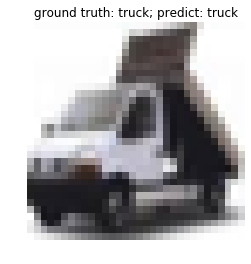

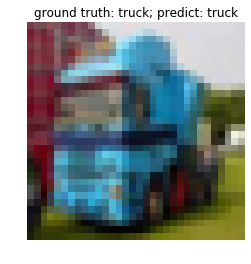

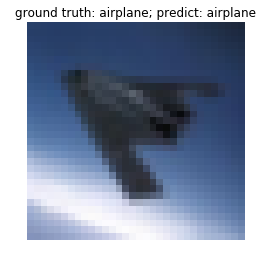

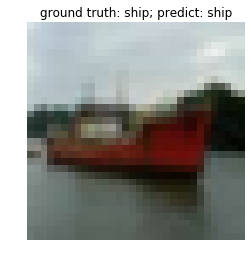

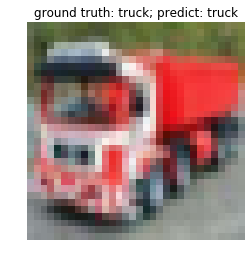

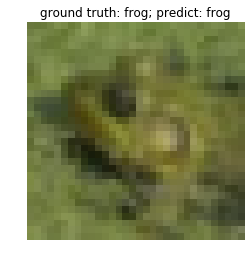

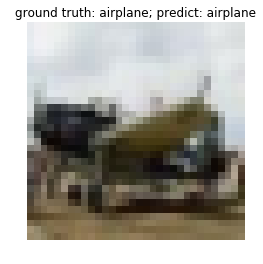

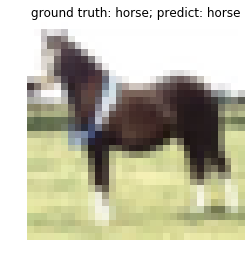

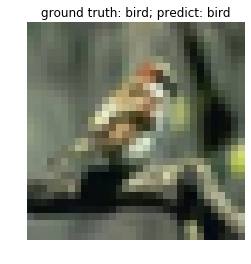

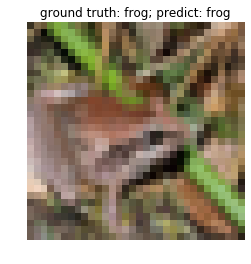

In [8]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
test_number = 10;
accurate_number = 0.0;
random.seed(7)
for iter in range(0, test_number):
    i = random.choice(range(0, 1000))
    predict = model.predict(x_test[i, :].reshape(1, 32, 32, 3));
    accurate_number += show_result(x_test[i], y_test[i], predict);
print('test_acc: ', accurate_number / test_number)